## Import thư viện

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os
from datasets import load_dataset
import pandas as pd
from PIL import Image

c:\Users\solit\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
# For Resnet34 and below

class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [3]:
# For Resnet50 and above

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out
        

In [4]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, kernel_size=7, stride=2, padding=3, num_classes=1000):
        super(Resnet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #ImageNet

        self.conv2_x = self.make_layer(block, 64, num_blocks[0])
        self.conv3_x = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4_x = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5_x = self.make_layer(block, 512, num_blocks[3], stride=2) #ImageNet

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = block.expansion * out_channels
        for idx in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) #ImageNet

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x) #ImageNet

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [5]:
class Resnet18(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[2, 2, 2, 2],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet34(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet50(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet101(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 23, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet152(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 8, 36, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

In [6]:
model = Resnet34(kernel_size=3, stride=1, padding=1, num_classes=200)
torchsummary.summary(model)
x = torch.randn(5, 3, 64, 64)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BuildingBlock: 2-1                --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Sequential: 3-6              --
|    └─BuildingBlock: 2-2                --
|    |    └─Conv2d: 3-7                  36,864
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Sequential: 3-12             --
|    └─BuildingBlock: 2-3                --
|    |    └─Conv2d: 3-13                 36,864

torch.Size([5, 200])

## TinyImageNet

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [8]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'train')
        self.classes = sorted(os.listdir(self.image_dir))
        self.images = []
        self.labels = []

        if split == 'train':
            for label_idx, class_dir in enumerate(self.classes):
                class_images = os.listdir(os.path.join(self.image_dir, class_dir, 'images'))
                for img_name in class_images:
                    img_path = os.path.join(self.image_dir, class_dir, 'images', img_name)
                    if self.is_rgb(img_path):
                        self.images.append(os.path.join(class_dir, 'images', img_name))
                        self.labels.append(label_idx)

        elif split == 'val':
            self.image_dir = os.path.join(root_dir, 'val', 'images')
            self.annotations_file = os.path.join(root_dir, 'val', 'val_annotations.txt')
            annotations = pd.read_csv(self.annotations_file, sep='\t', header=None)
            for img_name, label in zip(annotations[0], annotations[1]):
                img_path = os.path.join(self.image_dir, img_name)
                if self.is_rgb(img_path):
                    self.images.append(img_name)
                    self.labels.append(self.classes.index(label))

    def is_rgb(self, img_path):
        with Image.open(img_path) as img:
            return img.mode == 'RGB'

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label


In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4),  
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = TinyImageNetDataset(root_dir='./data/tiny-imagenet-200', split='train', transform=transform_train)
testset = TinyImageNetDataset(root_dir='./data/tiny-imagenet-200', split='val', transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


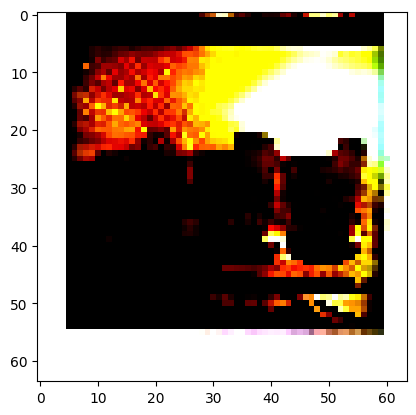

In [10]:
image = testset[2][0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [11]:
print(f'Size: {image.shape}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(testset.classes)}')

Size: (64, 64, 3)
Train: 98179
Test: 9832
Classes: 200


### Config

In [12]:
checkpoint_id = 1
folder_path = f'./Resnet/TinyImageNet/checkpoint{checkpoint_id}/'
kernel_size = 5
stride = 1
padding = 2
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001
step_size = 50

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "model": 'Resnet34',
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "step_size": step_size
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [13]:
model = Resnet34(kernel_size, stride, padding, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
print(model)

Resnet34(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### Train, test

In [14]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 

            outputs = model(inputs) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)
    

  1%|          | 1/100 [04:28<7:22:51, 268.39s/it]

Epoch [1/100], Loss: 4.6434


  2%|▏         | 2/100 [08:58<7:20:13, 269.53s/it]

Epoch [2/100], Loss: 3.8051


  3%|▎         | 3/100 [13:26<7:14:10, 268.56s/it]

Epoch [3/100], Loss: 3.4227


  4%|▍         | 4/100 [17:54<7:09:31, 268.45s/it]

Epoch [4/100], Loss: 3.1691


  5%|▌         | 5/100 [22:23<7:05:07, 268.50s/it]

Epoch [5/100], Loss: 2.9723


  6%|▌         | 6/100 [27:00<7:05:24, 271.53s/it]

Epoch [6/100], Loss: 2.8106


  7%|▋         | 7/100 [31:39<7:04:34, 273.92s/it]

Epoch [7/100], Loss: 2.6761


  8%|▊         | 8/100 [36:11<6:59:07, 273.34s/it]

Epoch [8/100], Loss: 2.5636


  9%|▉         | 9/100 [40:39<6:51:59, 271.64s/it]

Epoch [9/100], Loss: 2.4749


 10%|█         | 10/100 [45:07<6:45:43, 270.49s/it]

Epoch [10/100], Loss: 2.3849


 11%|█         | 11/100 [49:37<6:41:06, 270.41s/it]

Epoch [11/100], Loss: 2.3160


 12%|█▏        | 12/100 [54:16<6:40:29, 273.06s/it]

Epoch [12/100], Loss: 2.2544


 13%|█▎        | 13/100 [58:52<6:37:23, 274.07s/it]

Epoch [13/100], Loss: 2.2006


 14%|█▍        | 14/100 [1:03:24<6:31:51, 273.38s/it]

Epoch [14/100], Loss: 2.1490


 15%|█▌        | 15/100 [1:07:56<6:26:32, 272.85s/it]

Epoch [15/100], Loss: 2.1044


 16%|█▌        | 16/100 [1:12:27<6:21:17, 272.35s/it]

Epoch [16/100], Loss: 2.0690


 17%|█▋        | 17/100 [1:16:56<6:15:29, 271.44s/it]

Epoch [17/100], Loss: 2.0280


 18%|█▊        | 18/100 [1:21:26<6:10:04, 270.79s/it]

Epoch [18/100], Loss: 2.0021


 19%|█▉        | 19/100 [1:25:57<6:05:48, 270.97s/it]

Epoch [19/100], Loss: 1.9582


 20%|██        | 20/100 [1:30:29<6:01:31, 271.14s/it]

Epoch [20/100], Loss: 1.9360


 21%|██        | 21/100 [1:35:00<5:56:56, 271.10s/it]

Epoch [21/100], Loss: 1.9082


 22%|██▏       | 22/100 [1:39:31<5:52:25, 271.10s/it]

Epoch [22/100], Loss: 1.8896


 23%|██▎       | 23/100 [1:44:02<5:48:05, 271.24s/it]

Epoch [23/100], Loss: 1.8690


 24%|██▍       | 24/100 [1:48:36<5:44:31, 271.99s/it]

Epoch [24/100], Loss: 1.8492


 25%|██▌       | 25/100 [2:00:32<8:26:21, 405.09s/it]

Epoch [25/100], Loss: 1.8239


 26%|██▌       | 26/100 [2:07:53<8:32:56, 415.90s/it]

Epoch [26/100], Loss: 1.8068


 27%|██▋       | 27/100 [2:12:21<7:32:07, 371.61s/it]

Epoch [27/100], Loss: 1.7848


 28%|██▊       | 28/100 [2:16:49<6:48:41, 340.57s/it]

Epoch [28/100], Loss: 1.7696


 29%|██▉       | 29/100 [2:21:20<6:18:13, 319.63s/it]

Epoch [29/100], Loss: 1.7531


 30%|███       | 30/100 [2:25:52<5:56:20, 305.44s/it]

Epoch [30/100], Loss: 1.7405


 31%|███       | 31/100 [2:30:28<5:41:04, 296.59s/it]

Epoch [31/100], Loss: 1.7261


 32%|███▏      | 32/100 [2:35:04<5:28:57, 290.26s/it]

Epoch [32/100], Loss: 1.7126


 33%|███▎      | 33/100 [2:39:40<5:19:34, 286.19s/it]

Epoch [33/100], Loss: 1.7062


 34%|███▍      | 34/100 [2:44:19<5:12:11, 283.81s/it]

Epoch [34/100], Loss: 1.6864


 35%|███▌      | 35/100 [2:48:54<5:04:47, 281.35s/it]

Epoch [35/100], Loss: 1.6742


 36%|███▌      | 36/100 [2:53:31<4:58:41, 280.02s/it]

Epoch [36/100], Loss: 1.6695


 37%|███▋      | 37/100 [2:58:12<4:54:14, 280.23s/it]

Epoch [37/100], Loss: 1.6587


 38%|███▊      | 38/100 [3:02:54<4:50:12, 280.84s/it]

Epoch [38/100], Loss: 1.6378


 39%|███▉      | 39/100 [3:07:31<4:44:14, 279.58s/it]

Epoch [39/100], Loss: 1.6344


 40%|████      | 40/100 [3:12:08<4:39:02, 279.03s/it]

Epoch [40/100], Loss: 1.6272


 41%|████      | 41/100 [3:16:44<4:33:15, 277.88s/it]

Epoch [41/100], Loss: 1.6105


 42%|████▏     | 42/100 [3:21:20<4:28:18, 277.56s/it]

Epoch [42/100], Loss: 1.6084


 43%|████▎     | 43/100 [3:25:57<4:23:25, 277.29s/it]

Epoch [43/100], Loss: 1.5950


 44%|████▍     | 44/100 [3:30:28<4:17:04, 275.44s/it]

Epoch [44/100], Loss: 1.5877


 45%|████▌     | 45/100 [3:34:59<4:11:17, 274.14s/it]

Epoch [45/100], Loss: 1.5796


 46%|████▌     | 46/100 [3:39:38<4:07:56, 275.49s/it]

Epoch [46/100], Loss: 1.5784


 47%|████▋     | 47/100 [3:44:13<4:03:08, 275.25s/it]

Epoch [47/100], Loss: 1.5700


 48%|████▊     | 48/100 [3:48:41<3:56:38, 273.04s/it]

Epoch [48/100], Loss: 1.5600


 49%|████▉     | 49/100 [3:53:07<3:50:26, 271.12s/it]

Epoch [49/100], Loss: 1.5531


 50%|█████     | 50/100 [3:57:35<3:44:59, 269.99s/it]

Epoch [50/100], Loss: 1.5475


 51%|█████     | 51/100 [4:02:02<3:39:51, 269.22s/it]

Epoch [51/100], Loss: 1.2022


 52%|█████▏    | 52/100 [4:06:29<3:34:53, 268.62s/it]

Epoch [52/100], Loss: 1.0840


 53%|█████▎    | 53/100 [4:10:56<3:30:00, 268.10s/it]

Epoch [53/100], Loss: 1.0322


 54%|█████▍    | 54/100 [4:15:22<3:25:07, 267.56s/it]

Epoch [54/100], Loss: 0.9940


 55%|█████▌    | 55/100 [4:19:48<3:20:16, 267.03s/it]

Epoch [55/100], Loss: 0.9610


 56%|█████▌    | 56/100 [4:24:14<3:15:32, 266.64s/it]

Epoch [56/100], Loss: 0.9340


 57%|█████▋    | 57/100 [4:28:39<3:10:51, 266.32s/it]

Epoch [57/100], Loss: 0.9038


 58%|█████▊    | 58/100 [4:33:05<3:06:16, 266.10s/it]

Epoch [58/100], Loss: 0.8858


 59%|█████▉    | 59/100 [4:37:31<3:01:44, 265.95s/it]

Epoch [59/100], Loss: 0.8572


 60%|██████    | 60/100 [4:41:56<2:57:15, 265.89s/it]

Epoch [60/100], Loss: 0.8411


 61%|██████    | 61/100 [4:46:22<2:52:45, 265.78s/it]

Epoch [61/100], Loss: 0.8182


 62%|██████▏   | 62/100 [4:50:48<2:48:19, 265.77s/it]

Epoch [62/100], Loss: 0.7992


 63%|██████▎   | 63/100 [4:55:14<2:43:54, 265.79s/it]

Epoch [63/100], Loss: 0.7818


 64%|██████▍   | 64/100 [4:59:39<2:39:30, 265.84s/it]

Epoch [64/100], Loss: 0.7595


 65%|██████▌   | 65/100 [5:04:06<2:35:07, 265.92s/it]

Epoch [65/100], Loss: 0.7430


 66%|██████▌   | 66/100 [5:08:32<2:30:47, 266.09s/it]

Epoch [66/100], Loss: 0.7278


 67%|██████▋   | 67/100 [5:12:59<2:26:26, 266.25s/it]

Epoch [67/100], Loss: 0.7153


 68%|██████▊   | 68/100 [5:17:25<2:21:58, 266.21s/it]

Epoch [68/100], Loss: 0.6940


 69%|██████▉   | 69/100 [5:21:51<2:17:28, 266.07s/it]

Epoch [69/100], Loss: 0.6805


 70%|███████   | 70/100 [5:26:16<2:12:57, 265.93s/it]

Epoch [70/100], Loss: 0.6628


 71%|███████   | 71/100 [5:30:42<2:08:30, 265.87s/it]

Epoch [71/100], Loss: 0.6483


 72%|███████▏  | 72/100 [5:35:08<2:04:03, 265.83s/it]

Epoch [72/100], Loss: 0.6369


 73%|███████▎  | 73/100 [5:39:33<1:59:36, 265.78s/it]

Epoch [73/100], Loss: 0.6257


 74%|███████▍  | 74/100 [5:43:58<1:55:05, 265.60s/it]

Epoch [74/100], Loss: 0.6087


 75%|███████▌  | 75/100 [5:48:24<1:50:38, 265.52s/it]

Epoch [75/100], Loss: 0.5951


 76%|███████▌  | 76/100 [5:52:49<1:46:13, 265.56s/it]

Epoch [76/100], Loss: 0.5827


 77%|███████▋  | 77/100 [5:57:15<1:41:50, 265.68s/it]

Epoch [77/100], Loss: 0.5677


 78%|███████▊  | 78/100 [6:01:41<1:37:26, 265.74s/it]

Epoch [78/100], Loss: 0.5568


 79%|███████▉  | 79/100 [6:06:07<1:32:59, 265.71s/it]

Epoch [79/100], Loss: 0.5446


 80%|████████  | 80/100 [6:10:33<1:28:35, 265.78s/it]

Epoch [80/100], Loss: 0.5329


 81%|████████  | 81/100 [6:14:59<1:24:11, 265.85s/it]

Epoch [81/100], Loss: 0.5223


 82%|████████▏ | 82/100 [6:19:25<1:19:46, 265.93s/it]

Epoch [82/100], Loss: 0.5128


 83%|████████▎ | 83/100 [6:23:51<1:15:21, 265.96s/it]

Epoch [83/100], Loss: 0.5007


 84%|████████▍ | 84/100 [6:28:17<1:10:55, 265.95s/it]

Epoch [84/100], Loss: 0.4877


 85%|████████▌ | 85/100 [6:32:43<1:06:28, 265.93s/it]

Epoch [85/100], Loss: 0.4801


 86%|████████▌ | 86/100 [6:37:08<1:02:00, 265.73s/it]

Epoch [86/100], Loss: 0.4714


 87%|████████▋ | 87/100 [6:41:34<57:34, 265.75s/it]  

Epoch [87/100], Loss: 0.4618


 88%|████████▊ | 88/100 [6:46:00<53:09, 265.77s/it]

Epoch [88/100], Loss: 0.4519


 89%|████████▉ | 89/100 [6:50:25<48:42, 265.71s/it]

Epoch [89/100], Loss: 0.4442


 90%|█████████ | 90/100 [6:54:51<44:16, 265.69s/it]

Epoch [90/100], Loss: 0.4318


 91%|█████████ | 91/100 [6:59:17<39:51, 265.69s/it]

Epoch [91/100], Loss: 0.4247


 92%|█████████▏| 92/100 [7:03:42<35:25, 265.74s/it]

Epoch [92/100], Loss: 0.4172


 93%|█████████▎| 93/100 [7:08:08<31:00, 265.74s/it]

Epoch [93/100], Loss: 0.4121


 94%|█████████▍| 94/100 [7:12:34<26:34, 265.82s/it]

Epoch [94/100], Loss: 0.4048


 95%|█████████▌| 95/100 [7:17:04<22:14, 266.91s/it]

Epoch [95/100], Loss: 0.3973


 96%|█████████▌| 96/100 [7:21:39<17:57, 269.46s/it]

Epoch [96/100], Loss: 0.3873


 97%|█████████▋| 97/100 [7:26:14<13:33, 271.00s/it]

Epoch [97/100], Loss: 0.3805


 98%|█████████▊| 98/100 [7:30:48<09:04, 272.10s/it]

Epoch [98/100], Loss: 0.3767


 99%|█████████▉| 99/100 [7:35:22<04:32, 272.68s/it]

Epoch [99/100], Loss: 0.3671


100%|██████████| 100/100 [7:39:57<00:00, 275.98s/it]

Epoch [100/100], Loss: 0.3641


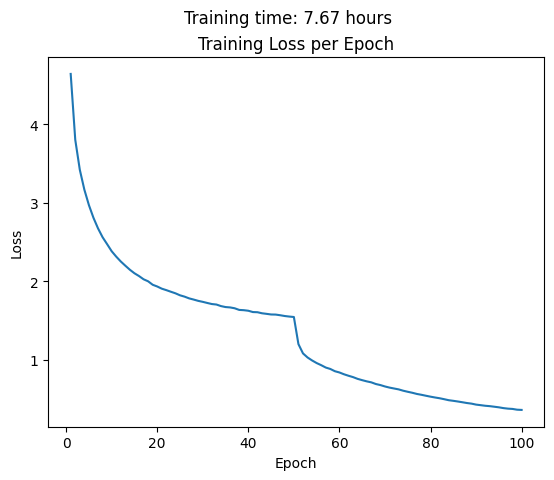

In [15]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [16]:
evaluate(model, testloader, device, folder_path)

Accuracy: 53.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        50
           1       0.81      0.76      0.78        50
           2       0.74      0.62      0.67        50
           3       0.41      0.36      0.38        50
           4       0.50      0.57      0.53        49
           5       0.41      0.40      0.40        50
           6       0.74      0.64      0.69        50
           7       0.61      0.44      0.51        50
           8       0.82      0.62      0.70        50
           9       0.57      0.64      0.60        50
          10       0.48      0.40      0.43        50
          11       0.52      0.68      0.59        47
          12       0.75      0.60      0.67        50
          13       0.53      0.64      0.58        50
          14       0.64      0.68      0.66        50
          15       0.56      0.45      0.50        49
          16       0.34      0.31      0.